In [1]:
import numpy as np
import itertools
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from natsort import index_natsorted

# Helper Functions - Run up to next header

These will eventually live in a python module, but keeping here for development

#### Compositions + Interpolation

In [2]:
#### name parsing helper functions
def components_to_name(components, delimiter = '_'):
    composition_label = ''
    for c, n in components.items():
        if n == 1:
            composition_label += '{0}{1}'.format(c, delimiter)            
        elif n > 0:
            nstr = f'{n:.3f}'.rstrip('0').rstrip('.')
            composition_label += '{0}{1}{2}'.format(c, nstr, delimiter)

    return composition_label[:-1]

def name_to_components(name, factor = 1, delimiter = '_'):
    '''
    given a chemical formula, returns dictionary with individual components/amounts
    expected name format = 'MA0.5_FA0.5_Pb1_I2_Br1'. 
    would return dictionary with keys ['MA, FA', 'Pb', 'I', 'Br'] and values [0.5,.05,1,2,1]*factor
    '''
    components = {}
    for part in name.split(delimiter):
        species = part
        count = 1.0
        for l in range(len(part), 0, -1):
            try:
                count = float(part[-l:])
                species = part[:-l]
                break
            except:
                pass
        components[species] = count * factor
    return components

#### individual solution functions

def get_components(name, factor = 1, delimiter = '_',):
    components = {}
    for part in name.split(delimiter):
        species = part
        count = 1.0
        for l in range(len(part), 0, -1):
            try:
                count = float(part[-l:])
                species = part[:-l]
                break
            except:
                pass
        components[species] = count * factor
    return components

def get_solvent(name):
    '''
    normalize solvent volumes -> solvent fractions
    '''
    solvent_dict = get_components(name)
    total = np.sum(list(solvent_dict.values()))
    return {solvent:amt/total for solvent,amt in solvent_dict.items()}

#### combining functions to generate experiment mesh

def compositions_spread(compositions, interp):
    interp += 1
    if interp <= 0:
        raise ValueError('interp must be > 0!')
        
    # load all unique components in spread,
    composition_components = [name_to_components(s) for s in compositions]
    components = []
    for s in composition_components:
        components += list(s.keys())
    components = np.unique(components)
    
    #sort by average order in endpoints (try to follow user convention for composition naming)
    component_order = np.full((len(components), len(composition_components)), np.nan)
    for n, s in enumerate(composition_components):
        for i, c in enumerate(s):
            m = np.where(components == c)[0]
            component_order[m,n] = i
    avg_order = np.argsort(np.nanmean(component_order, axis = 1))
    components = components[avg_order]

    #generate component matrix to interpolate between
    mat = np.zeros((len(compositions), len(components)))
    for sidx, s in enumerate(composition_components):
        for cidx, c in enumerate(components):
            if c in s:
                mat[sidx, cidx] = s[c]
    
    compositions = []
    for mix in itertools.combinations_with_replacement(mat, interp):
        composition_amounts = np.array(mix).mean(axis = 0)
        components_dict = {c:a for c,a in zip(components, composition_amounts)}
        compositions.append(components_to_name(components_dict)) #exclude the last underscore

    return list(np.unique(compositions))

#### Well Plate Handling

In [3]:
def well_list_generator(nrows = 12, ncols = 8, random = False):
    if not random:
        num = 0
        col = -1
        while num < nrows*ncols:
            row = num%nrows
            if row == 0:
                col += 1
            yield f'{str.upper(chr(col+97))}{row+1}'
            num += 1
    else:
        wells = []
        num = 0
        col = -1
        while num < nrows*ncols:
            row = num%nrows
            if row == 0:
                col += 1
            wells.append(f'{str.upper(chr(col+97))}{row+1}')
            num += 1

        idx = np.arange(nrows*ncols)
        np.random.shuffle(idx)

        for idx_ in idx:
            yield(wells[idx_])        


def generate_sample_list(compositions, solvents, molarities, volumes, randomize = True, repeats = 3, nrows = 12, ncols = 8):  
    samples = []
    plates = []
    well_generator = well_list_generator(nrows = nrows, ncols = ncols, random = randomize) 
    
    for c, s, m, v in itertools.product(compositions, solvents, molarities, volumes):
        for r in range(repeats):
            try:
                this_well = next(well_generator)
            except:
                raise Exception('Too many samples, well can only hold up to 96!')
            samples.append(dict(composition = c, solvent = s, molarity = m, volume = v, well = this_well))
    if randomize:
        random.shuffle(samples)
    return samples

In [4]:
def generate_composition_columns(df):
    components = set()
    for _,r in df.iterrows():
        for c in name_to_components(r['composition']):
            components.add(c)
    dfData = {c:[] for c in components}
    for _,r in df.iterrows():
        this_components = name_to_components(r['composition'])
        for c in components:
            dfData[c].append(this_components.get(c,0))
    df2 = pd.DataFrame(dfData)
    df = df.join(df2)
    return df

#### Mix Calculator

In [5]:
from scipy.optimize import nnls

def calculate_mix(target, target_solvent, volume, molarity, solution_sources, min_volume = 10e-6):
    # find unique solution components present in stock solutions
    solutes = set([c for stk in solution_sources for c in name_to_components(stk) if 'Solvent' not in stk])
    solvents = set([c for vals in solution_sources.values() for c in name_to_components(vals['solvent'])])
    
    ### Construct stock + target matrices
    row_key = {}
    i = 0
    for s in solutes:
        row_key[s] = i
        i += 1
    for s in solvents:
        row_key[s] = i
        i += 1
        
    stock_matrix = np.zeros((len(row_key), len(solution_sources)))
    wells = []
    for n, (name, vals) in enumerate(solution_sources.items()):
        wells.append(vals['well'])
        for solute, amt in get_components(name).items():
            if 'Solvent' in solute:
                continue
            m = row_key[solute]
            stock_matrix[m,n] = amt*vals['molarity']
        for solvent, amt in get_solvent(vals['solvent']).items():
            m = row_key[solvent]
            stock_matrix[m,n] = amt
    
    target_matrix = np.zeros((len(row_key)))
    for solute, amt in get_components(target).items():
        if 'Solvent' in solute:
            continue
        try:
            m = row_key[solute]
        except:
            raise Exception(f'{solute} not present in your stock solutions!')
        target_matrix[m] = amt*molarity*volume
    for solvent, amt in get_solvent(target_solvent).items():
        try:
            m = row_key[solvent]
        except:
            raise Exception(f'{solvent} not present in your stock solutions!')
        target_matrix[m] = amt*volume
    
#     amount_matrix, *data = np.linalg.lstsq(stock_matrix*1e6, target_matrix*1e6, rcond = None) #volumes to mix. math is better if not such small values in matrix, so scale to uL for calculation
    amount_matrix, *data = nnls(stock_matrix, target_matrix, maxiter=1e3) #volumes to mix. math is better if not such small values in matrix, so scale to uL for calculation
    amount_matrix[amount_matrix < 1e-6] = 0 #clean up values that are essentially 0. If we have a significant negative value here, should get caught downstream
    amount_matrix = np.round(amount_matrix,6) #round to nearest uL (values are in L at this point)
    
    doublecheck = stock_matrix @ amount_matrix
    composition_error = max([np.abs(1-c/t) for c,t in zip(doublecheck, target_matrix) if t>0])

    if composition_error < 0.05: #check that we are within 5% error wrt target composition AT EACH SITE
        results = {}
        for well, solution_volume in zip(wells, amount_matrix): 
            results[well] = solution_volume # round to nearest uL
    else:
        results = False
        target_achieved = components_to_name({c:amt/molarity/volume for c,amt in zip(row_key, doublecheck) if amt > 0})


        raise Exception(f'Unable to generate target solution ({volume*1e6} uL of {molarity}M {target} in'\
                        f'{target_solvent}) with current stock solutions.\n\n'\
                        f'Closest match is {target_achieved} - max site error of {composition_error*100:.2f}%')#{Off by {composition_error*100:.2f}%%')
    
#     if amount_matrix.sum() > volume:
#         raise Exception(f'Volume Overflow ({amount_matrix.sum()/volume})')
    return results

### Plotting

In [10]:
import ternary

def ternary_composition(cols):
    pts = np.array([sampledf[c].values for c in cols])

    ## Boundary and Gridlines
    scale = 1
    fig,ax=plt.subplots(figsize=(5,4))
    figure, tax = ternary.figure(ax=ax, scale=scale)

    # Draw Boundary and Gridlines
    tax.boundary(linewidth=0.5)
    tax.gridlines(color="black", multiple=0.2)
    # tax.gridlines(color="blue", multiple=1, linewidth=0.5)

    # Set Axis labels and Title
    fontsize = 20
    # tax.set_title("Simplex Boundary and Gridlines", fontsize=fontsize)
    tax.left_corner_label(cols[2], fontsize=fontsize)
    tax.right_corner_label(cols[0], fontsize=fontsize)
    tax.top_corner_label(cols[1], fontsize=fontsize)
    tax.right_axis_label('$\longleftarrow$\n', fontsize=fontsize/2)
    tax.bottom_axis_label('$\longrightarrow$', fontsize=fontsize/2)
    tax.left_axis_label('$\longleftarrow$\n', fontsize=fontsize/2)
    # tax.right_axis_label("Right label $\\beta^2$", fontsize=fontsize)
    # tax.bottom_axis_label("Bottom label $\\Gamma - \\Omega$", fontsize=fontsize)

    # Set ticks
    tax.ticks(axis='lbr', linewidth=0.1, ticks=[0.2,0.4,0.6,0.8], locations=[0.2,0.4,0.6,0.8], tick_formats='%.1f', offset=0.02)
    tax.scatter(pts.T, s=3, marker='x', c=[plt.cm.tab10(3)])
    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')


# Define Experimental Mesh (start here)

## Target Compositions

List of composition endpoints - these will be included in the experiment, and interpolated between if desired

component + amounts separated by underscores. No number implies 1

In [25]:
# composition_endpoints = [
#     'MA_Sn_I3',
#     'MA_Pb0.6_Sn0.4_I3',
#     'MA_Sn0.8_Bi0.2_I3',
#     'MA_Pb0.48_Sn0.32_Bi0.2_I3',
#     'MA_Sn0.8_Bi0.2_I3'

# ]

# compositions = compositions_spread(composition_endpoints, 3)

# print(f'==={len(compositions)} compositions===')
# for i, c in enumerate(compositions): print(f'{i}: {c}')

In [26]:
pbx = [0, 0.2, 0.4, 0.6] #MA_Sn(1-x)_Pb(x)_I3
# bix = np.linspace(0,0.1,11) #MA_SnPb(1-x)_Bi(x)_I3
bix = [0,0.01,0.02,0.03,0.04,0.05,0.075,0.1, 0.133, 0.166, 0.2]
compositions = []
for pb0 in pbx:
    for bi in bix:
        pb = pb0 * (1-bi)
        sn = (1-bi) * (1-pb0)
        compositions.append(f'MA_Sn{sn:.3f}_Pb{pb:.3f}_Bi{bi:.3f}_I3')
    
print(f'==={len(compositions)} compositions===')
for i, c in enumerate(compositions): print(f'{i}: {c}')

===44 compositions===
0: MA_Sn1.000_Pb0.000_Bi0.000_I3
1: MA_Sn0.990_Pb0.000_Bi0.010_I3
2: MA_Sn0.980_Pb0.000_Bi0.020_I3
3: MA_Sn0.970_Pb0.000_Bi0.030_I3
4: MA_Sn0.960_Pb0.000_Bi0.040_I3
5: MA_Sn0.950_Pb0.000_Bi0.050_I3
6: MA_Sn0.925_Pb0.000_Bi0.075_I3
7: MA_Sn0.900_Pb0.000_Bi0.100_I3
8: MA_Sn0.867_Pb0.000_Bi0.133_I3
9: MA_Sn0.834_Pb0.000_Bi0.166_I3
10: MA_Sn0.800_Pb0.000_Bi0.200_I3
11: MA_Sn0.800_Pb0.200_Bi0.000_I3
12: MA_Sn0.792_Pb0.198_Bi0.010_I3
13: MA_Sn0.784_Pb0.196_Bi0.020_I3
14: MA_Sn0.776_Pb0.194_Bi0.030_I3
15: MA_Sn0.768_Pb0.192_Bi0.040_I3
16: MA_Sn0.760_Pb0.190_Bi0.050_I3
17: MA_Sn0.740_Pb0.185_Bi0.075_I3
18: MA_Sn0.720_Pb0.180_Bi0.100_I3
19: MA_Sn0.694_Pb0.173_Bi0.133_I3
20: MA_Sn0.667_Pb0.167_Bi0.166_I3
21: MA_Sn0.640_Pb0.160_Bi0.200_I3
22: MA_Sn0.600_Pb0.400_Bi0.000_I3
23: MA_Sn0.594_Pb0.396_Bi0.010_I3
24: MA_Sn0.588_Pb0.392_Bi0.020_I3
25: MA_Sn0.582_Pb0.388_Bi0.030_I3
26: MA_Sn0.576_Pb0.384_Bi0.040_I3
27: MA_Sn0.570_Pb0.380_Bi0.050_I3
28: MA_Sn0.555_Pb0.370_Bi0.075_I3
29

In [27]:
indices_to_omit = [] #from list above

compositions = [c for i,c in enumerate(compositions) if i not in indices_to_omit]
print(f'==={len(compositions)} compositions===')
for i, c in enumerate(compositions): print(f'{i}: {c}')

===44 compositions===
0: MA_Sn1.000_Pb0.000_Bi0.000_I3
1: MA_Sn0.990_Pb0.000_Bi0.010_I3
2: MA_Sn0.980_Pb0.000_Bi0.020_I3
3: MA_Sn0.970_Pb0.000_Bi0.030_I3
4: MA_Sn0.960_Pb0.000_Bi0.040_I3
5: MA_Sn0.950_Pb0.000_Bi0.050_I3
6: MA_Sn0.925_Pb0.000_Bi0.075_I3
7: MA_Sn0.900_Pb0.000_Bi0.100_I3
8: MA_Sn0.867_Pb0.000_Bi0.133_I3
9: MA_Sn0.834_Pb0.000_Bi0.166_I3
10: MA_Sn0.800_Pb0.000_Bi0.200_I3
11: MA_Sn0.800_Pb0.200_Bi0.000_I3
12: MA_Sn0.792_Pb0.198_Bi0.010_I3
13: MA_Sn0.784_Pb0.196_Bi0.020_I3
14: MA_Sn0.776_Pb0.194_Bi0.030_I3
15: MA_Sn0.768_Pb0.192_Bi0.040_I3
16: MA_Sn0.760_Pb0.190_Bi0.050_I3
17: MA_Sn0.740_Pb0.185_Bi0.075_I3
18: MA_Sn0.720_Pb0.180_Bi0.100_I3
19: MA_Sn0.694_Pb0.173_Bi0.133_I3
20: MA_Sn0.667_Pb0.167_Bi0.166_I3
21: MA_Sn0.640_Pb0.160_Bi0.200_I3
22: MA_Sn0.600_Pb0.400_Bi0.000_I3
23: MA_Sn0.594_Pb0.396_Bi0.010_I3
24: MA_Sn0.588_Pb0.392_Bi0.020_I3
25: MA_Sn0.582_Pb0.388_Bi0.030_I3
26: MA_Sn0.576_Pb0.384_Bi0.040_I3
27: MA_Sn0.570_Pb0.380_Bi0.050_I3
28: MA_Sn0.555_Pb0.370_Bi0.075_I3
29

Note that you can manually enter compositions if no meshing is desired

In [28]:
# compositions = [
#     'MA_Sn_I3',
#     'MA_Sn0.2_Bi0.8_I3'
# ]

## Target Solvents

Define solvent systems to use. at least one must be defined here. Same approach as above, but here we only care about solvent component _ratios_, ie `DMF0.5_DMSO0.5` and `DMF_DMSO` are equivalent

In [29]:
# endpoint_solvents = [
#     'DMSO',
#     'DMF'
# ]

In [30]:
# solvents = compositions_spread(
#     compositions = endpoint_solvents, 
#     n = 1
# )

# print(f'==={len(solvents)} solvent systems===')
# for i, c in enumerate(solvents): print(f'{i}: {c}')

In [31]:
# indices_to_omit = [] #from list above

# solvents = [c for i,c in enumerate(solvents) if i not in indices_to_omit]
# print(f'==={len(solvents)} solvent systems===')
# for i, c in enumerate(solvents): print(f'{i}: {c}')

Usually we dont need a substantial mesh of solvents, and we can define them manually.

In [32]:
solvents = [
    'DMF4_DMSO1'
]

## Generate Sample List

List your molarities and volumes, and importantly the number of repeats and whether to randomize the sample + well order or not. 

Randomization is desirable to reduce systematic effects (conditions drifting over time, or edge vs center well plate effects), but obviously makes interpreting your data a bit more involved.

In [33]:
molarities = [0.5] #target solution molarities
volumes = [60e-6] #target solution volume(s)

samples = generate_sample_list(
    compositions = compositions,
    solvents = solvents,
    molarities = molarities,
    volumes = volumes,
    randomize = True, #boolean, randomize well + sample order
    repeats = 2 #number of duplicates per unique experimental point
)
print(f'{len(samples)}/96 Wells Occupied')

88/96 Wells Occupied


In [34]:
sampledf = pd.DataFrame(samples)
# sampledf = pd.read_csv('wellplate_key_ACTUALLYUSED.csv', index_col = None, usecols = [1,2,3,4]) #load connor's actual run
sampledf = generate_composition_columns(sampledf)
sampledf['row'] = sampledf['well'].apply(lambda x: x[0])
sampledf['col'] = sampledf['well'].apply(lambda x: int(x[1:]))
sampledf.set_index('well', inplace = True)
sampledf.sort_values(
    by="well",
    key=lambda x: np.argsort(index_natsorted(x)),
    inplace=True
)
sampledf.head() #display first five rows

,composition,solvent,molarity,volume,Sn,I,Bi,Pb,MA,row,col
well,,,,,,,,,,,
A1,MA_Sn0.960_Pb0.000_Bi0.040_I3,DMF4_DMSO1,0.5,0.00006,0.960,3.0,0.040,0.000,1.0,A,1
A2,MA_Sn0.950_Pb0.000_Bi0.050_I3,DMF4_DMSO1,0.5,0.00006,0.950,3.0,0.050,0.000,1.0,A,2
A3,MA_Sn0.380_Pb0.570_Bi0.050_I3,DMF4_DMSO1,0.5,0.00006,0.380,3.0,0.050,0.570,1.0,A,3
A4,MA_Sn0.667_Pb0.167_Bi0.166_I3,DMF4_DMSO1,0.5,0.00006,0.667,3.0,0.166,0.167,1.0,A,4
A5,MA_Sn0.900_Pb0.000_Bi0.100_I3,DMF4_DMSO1,0.5,0.00006,0.900,3.0,0.100,0.000,1.0,A,5


## Stock Solution Setup

Define your stock solutions. These need to have compositions and molarities spanning the edges of your experimental space. The wells are for your own record, and should correspond to the well location on the stock solution deck on the liquid handler. solvent systems and compositions are defined with the same convention as earlier.

All solvent-only solutions should be named with a `Solvent_` prefix. The `molarity` value for solvents is a dummy value not used for anything, and the `solvent` value should reflect the solvent ratio. Adding plain solvent is only needed if you want to dilute molarities.

In [4]:
stock_solutions = {
    'MA_Sn_I3': dict(well = 'A7', molarity = 0.5, solvent = 'DMF4_DMSO1'),
    'MA_Pb_I3': dict(well = 'B7', molarity = 0.5, solvent = 'DMF4_DMSO1'),
    'MA_Sn0.8_Bi0.2_I3': dict(well = 'C7', molarity = 0.5, solvent = 'DMF4_DMSO1'),
    'MA_Pb0.8_Bi0.2_I3': dict(well = 'D7', molarity = 0.5, solvent = 'DMF4_DMSO1'),
#     'Solvent_DMF4_DMSO1': dict(well = 'B1', molarity = 1, solvent = 'DMF4_DMSO1'),
}
stock_wells = {v['well']:comp for comp,v in stock_solutions.items()}

Some constants to make sure your stock doesnt go dry during handling. can vary based on stock vials

In [5]:
min_volume_to_aspirate = 0.5e-3 #volume (L) below which the liquid level in the is too low to properly aspirate
overhead = 0.05 #fraction of total volume you want to add as overhead. 0.1 = 10% extra

### Calculate necessary stock volumes

In [6]:
necessary_stock = {v['well']:0 for v in stock_solutions.values()}
stockdfData = {w:[] for w in list(stock_wells.keys()) + ['well']}

for i, s in enumerate(samples):
    this_mix = calculate_mix(s['composition'], s['solvent'], s['volume'], s['molarity'], stock_solutions) 
    for well, amount in this_mix.items():
        necessary_stock[well] += amount
    for well in stock_wells:
        stockdfData[well].append(this_mix.get(well, 0))
    stockdfData['well'].append(s['well'])
    samples[i]['stock_mixture'] = this_mix


for stock, amt in necessary_stock.items():
    if amt > 0:
        necessary_stock[stock] = amt*(1+overhead) + min_volume_to_aspirate
# necessary_stock = {w:amt*(1+overhead) + min_volume_to_aspirate for w, amt in necessary_stock.items() if amt > 0}
print('=== Stock Solution Volumes Necessary === ')
for well, amt_needed in necessary_stock.items():
    print(f'{well} ({stock_wells[well]})\t{amt_needed*1000:.2f} mL')

NameError: name 'samples' is not defined

In [38]:
def volume_necessary(well):
    return necessary_stock[well]*1e3

stockdf = pd.DataFrame(stock_solutions).T
stockdf.sort_values(
    by="well",
    key=lambda x: np.argsort(index_natsorted(x)),
    inplace=True
)
stockdf['volume (mL)'] = stockdf['well'].apply(volume_necessary)
display(stockdf)

,well,molarity,solvent,volume (mL)
MA_Sn_I3,A7,0.5,DMF4_DMSO1,2.8583
MA_Pb_I3,B7,0.5,DMF4_DMSO1,1.6025
MA_Sn0.8_Bi0.2_I3,C7,0.5,DMF4_DMSO1,2.0309
MA_Pb0.8_Bi0.2_I3,D7,0.5,DMF4_DMSO1,1.0418


## Visualize Well Plate

Can copy the following cell and change the "column" value to any columns present in the sampledf dataframe displayed above ^^

colormaps can be changed using `palette` argument. possible values in these references
- https://seaborn.pydata.org/tutorial/color_palettes.html
- https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html

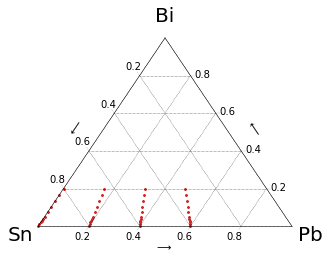

In [15]:
ternary_composition(['Pb', 'Bi', 'Sn'])
plt.savefig('SnPbBi_tern', dpi=300, bbox_inches='tight')

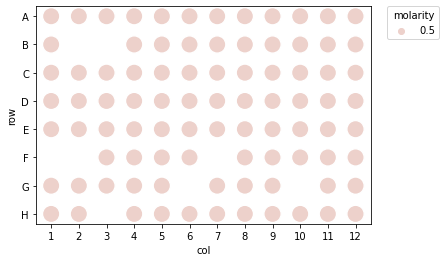

In [40]:
column = 'molarity'

sns.scatterplot(
    data = sampledf,
    x = 'col',
    y = 'row',
    hue = column,
    s = 300
)
plt.xticks(np.arange(1,13))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = column)
plt.savefig('Molarity', bbox_inches = 'tight')
plt.show()

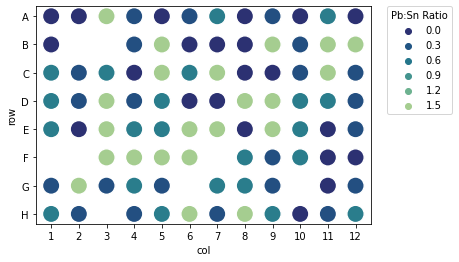

In [41]:
sns.scatterplot(
    data = sampledf,
    x = 'col',
    y = 'row',
    hue = sampledf['Pb']/sampledf['Sn'],
    palette = 'crest_r', 
    s = 300
)
plt.xticks(np.arange(1,13))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = 'Pb:Sn Ratio')
plt.savefig('Pb-Sn Ratio', bbox_inches = 'tight')
plt.show()

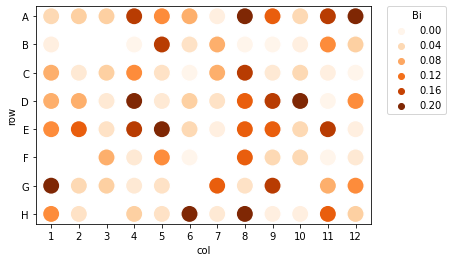

In [42]:
column = 'Bi'

sns.scatterplot(
    data = sampledf,
    x = 'col',
    y = 'row',
    hue = column,
    palette = 'Oranges', 
    s = 300
)
plt.xticks(np.arange(1,13))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = column)
plt.savefig('Bi Loading', bbox_inches = 'tight')
plt.show()

# Export Files

In [2]:
sampledf = pd.read_csv('samples.csv')

#### Sample Table

In [43]:
def add_stock_volume_columns(sampledf):
    stockcols = [c for c in sampledf.columns if 'stock volume' not in c]
    sampledf = sampledf[stockcols]
    df = pd.DataFrame(stockdfData)
    df.set_index('well', inplace = True)
    df = df.rename(columns = {c:f'{c} stock volume' for c in df.columns})
    sampledf = sampledf.join(df)
    return sampledf

sampledf = add_stock_volume_columns(sampledf)

In [45]:
sampledf.head()

,composition,solvent,molarity,volume,Sn,I,Bi,Pb,MA,row,col,A7 stock volume,B7 stock volume,C7 stock volume,D7 stock volume
well,,,,,,,,,,,,,,,
A1,MA_Sn0.960_Pb0.000_Bi0.040_I3,DMF4_DMSO1,0.5,0.00006,0.960,3.0,0.040,0.000,1.0,A,1,0.000048,0.000000,0.000012,0.000000
A2,MA_Sn0.950_Pb0.000_Bi0.050_I3,DMF4_DMSO1,0.5,0.00006,0.950,3.0,0.050,0.000,1.0,A,2,0.000045,0.000000,0.000015,0.000000
A3,MA_Sn0.380_Pb0.570_Bi0.050_I3,DMF4_DMSO1,0.5,0.00006,0.380,3.0,0.050,0.570,1.0,A,3,0.000023,0.000022,0.000000,0.000015
A4,MA_Sn0.667_Pb0.167_Bi0.166_I3,DMF4_DMSO1,0.5,0.00006,0.667,3.0,0.166,0.167,1.0,A,4,0.000000,0.000010,0.000050,0.000000
A5,MA_Sn0.900_Pb0.000_Bi0.100_I3,DMF4_DMSO1,0.5,0.00006,0.900,3.0,0.100,0.000,1.0,A,5,0.000030,0.000000,0.000030,0.000000


In [46]:
sampledf.to_csv('samples.csv')

#### Stock Solution Table

In [47]:
stockdf.head()

,well,molarity,solvent,volume (mL)
MA_Sn_I3,A7,0.5,DMF4_DMSO1,2.8583
MA_Pb_I3,B7,0.5,DMF4_DMSO1,1.6025
MA_Sn0.8_Bi0.2_I3,C7,0.5,DMF4_DMSO1,2.0309
MA_Pb0.8_Bi0.2_I3,D7,0.5,DMF4_DMSO1,1.0418


In [48]:
stockdf.to_csv('stock_solutions.csv')

#### Liquid Handler Instructions

No need to change anything here - if you are happy with everything you set up above, this section creates a json string of volume transfers for the liquid handler. The output file `transfer_list.json` will be copy-pasted into the liquid handler protocol file.

In [7]:
transfers = {well:dict(destination_wells = [], transfer_volumes = [])  for well in stock_wells}

sample_by_well = {s['well']:s for s in samples}
empty = dict(stock_mixture = {well:0 for well in stock_wells})

for well in well_list_generator(random = False):
    amts = sample_by_well.get(well, empty)['stock_mixture']
    for stock_well, stock_volume in amts.items():
        transfers[stock_well]['destination_wells'].append(well)
        transfers[stock_well]['transfer_volumes'].append(stock_volume*1e6) #robot takes inputs in uL

NameError: name 'samples' is not defined

In [50]:
with open('transfer_list.json', 'w') as f:
    json.dump(transfers, f)